In [34]:
from utils import *
from sklearn.decomposition import NMF
df = pd.read_csv('../Processing/data_list.csv')

row = df.iloc[5]
save_root = row['save_dir']+'/'
print(row['dat_dir'])

brain_map = np.load(save_root+'Y_ave.npy')
trans_ = np.load(save_root+'trans_affs.npy')


processed_dir = row['dat_dir'] + 'processed/'
CL_path = processed_dir + 'CL_trials.pkl'
OL_path = processed_dir + 'OL_trials.pkl'

/nrs/ahrens/jing/state_modulation/LG_vs_NGGU/20191130/fish00/6dpf_HuC-GC7FF_GU-fwd_fish00_exp02_20191130_151303/


In [2]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

### Check if all time points were valid in registration

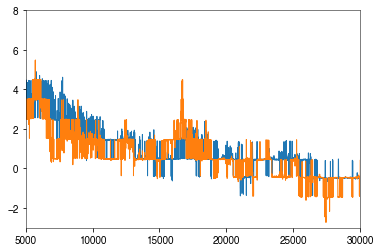

In [3]:
plt.plot(trans_[:, 1, -1])
plt.plot(trans_[:, 2, -1])
plt.ylim([-3, 8])
t_max=30000
t_min=5000
plt.xlim([t_min, t_max])
plt.show()

In [4]:
_ = np.load(save_root+'cell_dff.npz', allow_pickle=True)
A = _['A']
A_loc = _['A_loc']
dFF = _['dFF'].astype('float')
_ = None

### PCA on whole trial

#### PCA for the whole brain

In [5]:
# zdFF = zscore(dFF, axis=-1)
# pca = PCA(n_components=1000)
# pca.fit(zdFF)
# plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)

#### PCA for each plan

In [6]:
# zmax = A_loc[:,0].max()+1
# pca = PCA(n_components=300)
# for nz in range(zmax):
#     pca.fit(zdFF[A_loc[:,0]==nz])
#     plt.figure()
#     plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
#     plt.show()

### Analysis based on the task relevant period

In [9]:
CL_trials = pd.read_pickle(CL_path)
OL_trials = pd.read_pickle(OL_path)
trial_list = [CL_trials, OL_trials]
epoch_list = []
trial_type = []
time_list = []
for n, _ in enumerate(trial_list):
    for ntrial in range(len(_)):
        epoch_ = _.iloc[ntrial]['epoch_im2ep']
        indx = ep2frame(_.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
        trial_type.append(n)
        epoch_list.append(epoch_[indx])
        time_list.append(_.iloc[ntrial]['ds_trial_inds'])

### Sensory time

In [15]:
sensory_time = []
motor_time = []
for n_, _ in enumerate(time_list):
    n = trial_type[n_]
    valid_ = np.where((epoch_list[n_]>=(n*5)) & (epoch_list[n_]<=(n*5+1)))[0]
    motor_time.append(_[valid_.min():valid_.max()+10])
    valid_ = np.where(epoch_list[n_]==(n*5+3))[0]
    sensory_time.append(_[valid_.min()-10:valid_.max()+10])

In [18]:
motor_time = np.concatenate(motor_time)
sensory_time = np.concatenate(sensory_time)

In [26]:
sdFF = dFF[:, sensory_time]
mdFF = dFF[:, motor_time]

In [30]:
zdFF = zscore(sdFF, axis=-1)

In [ ]:
pca = PCA(n_components=1000)
pca.fit(zdFF.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)

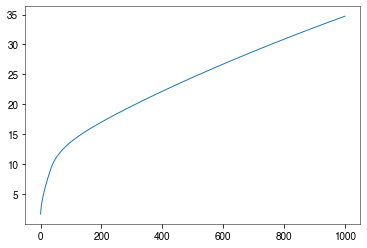

In [35]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)

In [61]:
from scipy.stats import spearmanr
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm

### remove white-noise like cells from analyses

In [62]:
num_cell = zdFF.shape[0]
valid_ = np.zeros(num_cell).astype('bool')
for n_cell in tqdm(range(num_cell)):
    _, p = acorr_ljungbox(zdFF[0], lags=30)
    if (p<.05).sum()>0:
        valid_[n_cell]=True
sensory_valid_ = valid_.copy()

100%|██████████| 162228/162228 [20:08<00:00, 134.24it/s]


In [105]:
num_z = A_loc[:,0].max()+1
valid_ = np.zeros(num_cell).astype('bool')
corr_thres = 0.2
corr_size=10
for nz in tqdm(range(num_z)):
    nz_list = np.where(A_loc[:,0]==nz)[0]
    corr_, p_ = spearmanr(zdFF[nz_list], axis=1)
    valid_thres = ((p_<0.05).sum(axis=-1)>10) & ((np.abs(corr_)>corr_thres).sum(axis=-1)>corr_size)
    valid_[nz_list[valid_thres]]=True
sensory_corr_valid_=valid_.copy()

In [106]:
sensory_zdFF=zdFF[sensory_corr_valid_ & sensory_valid_]

In [ ]:
corr_, p_ = spearmanr(sensory_zdFF, axis=1)

In [ ]:
plt.matshow(corr_, vmax=1, vmin=-1)

In [52]:
spearmanr(zdFF, axis=1)corr_, p_=

MemoryError: Unable to allocate 196. GiB for an array with shape (162228, 162228) and data type float64

### Motor time

In [12]:
len(time_list)

25

In [ ]:
for cell_id in range(dFF.shape[0]):
    dFF_cell = dFF[cell_id]
    dFF_cell_list = []
    for _ in time_list:
        dFF_cell_list.append(dFF_cell[_])
    dFF_mat = np.zeros((len_, max_t))
    dFF_mat[:] = np.nan
    for n_ in range(len_):
        n = trial_type[n_]
        valid_ = (epoch_list[n_]>=(n*5)) & (epoch_list[n_]<(n*5+5))
        t_ = valid_.sum()
        dFF_mat[n_, :t_] = dFF_cell_list[n_][valid_]
    for ntime in range(120):
        _, p = ranksums(dFF_mat[np.array(trial_type)==0, ntime], dFF_mat[np.array(trial_type)==1, ntime])
        p_list[cell_id, ntime] = p
np.save(save_root+'p_value', p_list)

In [ ]:
dFF.shape

### NMF

In [ ]:
nmf_ = NMF(n_components=200, max_iter=2000, verbose=True)

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
X = dFF - np.percentile(dFF, 1, axis=-1, keepdims=True)
dFF = None
X_sparse = X.copy()
X_sparse[X_sparse<=0]=0
X_sparse = csr_matrix(X_sparse)

In [ ]:
dFF = None
X = None

In [ ]:
def sparse_corrcoef(A):
    n = A.shape[-1]
    rowsum = A.sum(axis=-1)
    c_ = rowsum.dot(rowsum.T)/n
    C = (A.dot(A.T) - C)/(n-1)
    d = np.diag(C)
    return C/np.sqrt(np.outer(d, d))

In [ ]:
corr_ = sparse_corrcoef(X_sparse)

In [ ]:
corr_.shape

In [ ]:
import pandas as pd

CL_trials = pd.read_pickle(CL_path)
OL_trials = pd.read_pickle(OL_path)
trial_list = [CL_trials, OL_trials]

## Open loop vs close loop difference cells

In [ ]:
from scipy.stats import ranksums
len_ = len(trial_type)
max_t = np.array([len(_) for _ in time_list]).max()
p_list = np.zeros((dFF.shape[0], 120))
for cell_id in range(dFF.shape[0]):
    dFF_cell = dFF[cell_id]
    dFF_cell_list = []
    for _ in time_list:
        dFF_cell_list.append(dFF_cell[_])
    dFF_mat = np.zeros((len_, max_t))
    dFF_mat[:] = np.nan
    for n_ in range(len_):
        n = trial_type[n_]
        valid_ = (epoch_list[n_]>=(n*5)) & (epoch_list[n_]<(n*5+5))
        t_ = valid_.sum()
        dFF_mat[n_, :t_] = dFF_cell_list[n_][valid_]
    for ntime in range(120):
        _, p = ranksums(dFF_mat[np.array(trial_type)==0, ntime], dFF_mat[np.array(trial_type)==1, ntime])
        p_list[cell_id, ntime] = p
np.save(save_root+'p_value', p_list)

In [ ]:
p_list = np.load(save_root+'p_value.npy')

In [ ]:
plt.plot(epoch_list[40])

In [ ]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(A):
    if (p_list[n_, 20:]<0.05).mean()<0.12:
        continue
    A_loc_ = A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()

_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [ ]:
sub_indx = (p_list[:, 20:]<0.05).mean(axis=-1)>0.12
print(f'number of cell segments in analysis: {sub_indx.sum()}')

In [ ]:
dFF_ave = dFF[sub_indx].mean(axis=0)

In [ ]:
len_ = len(trial_type)
max_t = np.array([len(_) for _ in time_list]).max()
dFF_cell_list = []
for _ in time_list:
    dFF_cell_list.append(dFF_ave[_])
dFF_mat = np.zeros((len_, max_t))
dFF_mat[:] = np.nan
for n_ in range(len_):
    n = trial_type[n_]
    valid_ = (epoch_list[n_]>=(n*5)) & (epoch_list[n_]<(n*5+5))
    t_ = valid_.sum()
    dFF_mat[n_, :t_] = dFF_cell_list[n_][valid_]

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==0].mean(axis=0))
plt.plot(dFF_mat[np.array(trial_type)==1].mean(axis=0))
plt.xlim([0, 150])
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==0].T)
plt.xlim([0, max_t])
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==1].T)
plt.xlim([0, max_t])
plt.show()

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(CL_trials.iloc[0]['swimpower_im2ep'])
plt.plot(CL_trials.iloc[0]['swimming_im2ep']*np.median(CL_trials.iloc[0]['swimpower_im2ep']))
plt.show()

In [ ]:
swim_power = CL_trials.iloc[0]['swimpower_im2ep']

In [ ]:
indx = ep2frame(CL_trials.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
swim_power_frame = [swim_power[indx[n]:indx[n+1]].mean() for n in range(len(indx)-1)]
swim_power_frame.append(min(swim_power_frame))
swim_power_frame = np.array(swim_power_frame)

In [ ]:
swim_power_frame.shape

In [ ]:
def frame_swim_power(swim_power, indx):
    swim_power_frame = [swim_power[indx[n]:indx[n+1]].mean() for n in range(len(indx)-1)]
    swim_power_frame.append(min(swim_power_frame))
    return np.array(swim_power_frame)

In [ ]:
epoch_list = []
trial_type = []
time_list = []
pulse_probe_list = []
swim_power_list = []
for n, _ in enumerate(trial_list):
    for ntrial in range(len(_)):
        epoch_ = _.iloc[ntrial]['epoch_im2ep']
        swim_power = _.iloc[ntrial]['swimpower_im2ep']
        indx = ep2frame(_.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
        pulse_ = _.iloc[ntrial]['cmdvel_im2ep'][indx]
        trial_type.append(n)
        epoch_list.append(epoch_[indx])
        time_list.append(_.iloc[ntrial]['ds_trial_inds'])
        pulse_probe_list.append((pulse_==pulse_.max())&(epoch_[indx]==(n*5+3)))
        swim_power_list.append(frame_swim_power(swim_power, indx))

In [ ]:
(np.array(trial_type)==0).sum()

In [ ]:
n_ = 20
plt.plot((pulse_probe_list[n_]).astype('float')*swim_power_list[n_].max())
plt.plot(swim_power_list[n_])
plt.savefig('tmp.pdf')

## Pulse neurons with activity different in CL vs OL

In [ ]:
sig_cell_dFF = dFF[sub_indx]
sig_cell_A = A[sub_indx]
sig_cell_A_loc = A_loc[sub_indx]
sig_cell_num = sig_cell_dFF.shape[0]

In [ ]:
from scipy.stats import ranksums

In [ ]:
pulse_cell = np.zeros((sig_cell_num, len(trial_type)))

for n_ in range(sig_cell_num):
    dFF_cell = sig_cell_dFF[n_]
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        pulse_ = pulse_probe_list[m][epoch_==(trial_type[m]*5+3)]
        dFF_trial = dFF_cell[_][epoch_==(trial_type[m]*5+3)]
        _, p = ranksums(dFF_trial[pulse_==0], dFF_trial[pulse_==1])
        pulse_cell[n_, m] = p

In [ ]:
pulse_indx = (pulse_cell<0.05).mean(axis=-1)>0.6

In [ ]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(sig_cell_A):
    if not pulse_indx[n_]:
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     if (_>0).sum()==0:
#         continue
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()
_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [ ]:
cell_act_CL = np.zeros((pulse_indx.sum(), 400))
cell_act_OL = np.zeros((pulse_indx.sum(), 400))
for n_, dFF_cell in enumerate(sig_cell_dFF[pulse_indx]):
    dFF_trial = np.zeros((len(time_list), 400))
    dFF_trial[:] = np.nan
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        indx_ = epoch_==(trial_type[m]*5+3)
        t_ = indx_.sum()
        dFF_trial[m, :t_] = dFF_cell[_][indx_]
    cell_act_CL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==0, :], axis=0)
    cell_act_OL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==1, :], axis=0)

In [ ]:
import seaborn as sns
sns.set_style('ticks')

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_CL[:, :240]/cell_act_CL[:, :240].max(axis=-1, keepdims=True), aspect='auto', extent=(0, 240/3.5,1, cell_act_CL.shape[0]), vmax=1, vmin=0)
plt.yticks([1, cell_act_CL.shape[0]])
plt.xticks(np.arange(0, 25, 5))
plt.xlim([0, 20])
plt.colorbar()
sns.despine()
plt.savefig('tmp1.pdf')

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_OL[:, :240]/cell_act_CL[:, :240].max(axis=-1, keepdims=True), aspect='auto', extent=(0, 240/3.5,1, cell_act_CL.shape[0]), vmax=1, vmin=0)
plt.yticks([1, cell_act_CL.shape[0]])
plt.xticks(np.arange(0, 25, 5))
plt.xlim([0, 20])
sns.despine()
plt.savefig('tmp2.pdf')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(240)/3.5, cell_act_CL[:, :240].mean(axis=0)*100)
plt.plot(np.arange(240)/3.5, cell_act_OL[:, :240].mean(axis=0)*100)
plt.xlim([0, 20])
sns.despine()
plt.savefig('tmp3.pdf')

## Motor neurons with activity different in CL vs OL

In [ ]:
motor_cell = np.zeros((sig_cell_num, 70))

for n_ in range(sig_cell_num):
    dFF_cell = sig_cell_dFF[n_]
    dFF_trial_list = np.zeros((len(time_list), 70))
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        motor_ = pulse_probe_list[m][epoch_==(trial_type[m]*5+1)]
        dFF_trial = dFF_cell[_][epoch_==(trial_type[m]*5+1)]
        t_len = len(dFF_trial)
        dFF_trial_list[m, :t_len] = dFF_trial
    for ntime in range(70):
        _, p = ranksums(dFF_trial_list[np.array(trial_type)==0, ntime], dFF_trial_list[np.array(trial_type)==1, ntime])
        motor_cell[n_, ntime] = p

In [ ]:
motor_cell = motor_cell[:, :40]

In [ ]:
motor_indx = (motor_cell<0.05).mean(axis=-1)>0.9
print(f'number of motor cell: {motor_indx.sum()}')

In [ ]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(sig_cell_A):
    if not motor_indx[n_]:
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     if (_>0).sum()==0:
#         continue
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()
_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [ ]:
cell_act_CL = np.zeros((motor_indx.sum(), 80))
cell_act_OL = np.zeros((motor_indx.sum(), 80))
for n_, dFF_cell in enumerate(sig_cell_dFF[motor_indx]):
    dFF_trial = np.zeros((len(time_list), 80))
    dFF_trial[:] = np.nan
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        indx_ = epoch_==(trial_type[m]*5+1)
        t_ = indx_.sum()
        dFF_trial[m, :t_] = dFF_cell[_][indx_]
    cell_act_CL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==0, :], axis=0)
    cell_act_OL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==1, :], axis=0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_CL[:, :40]/cell_act_CL[:, :40].max(axis=-1, keepdims=True), aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_OL[:, :40]/cell_act_CL[:, :40].max(axis=-1, keepdims=True), aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cell_act_CL[:, :40].mean(axis=0))
plt.plot(cell_act_OL[:, :40].mean(axis=0))
plt.show()

## Overlay pulse and motor neurons

In [ ]:
A_ext = np.zeros((brain_map.shape[1], brain_map.shape[2], 3))
z_ = brain_map.shape[0]
for n_, A_ in enumerate(sig_cell_A):
    if (not pulse_indx[n_]) and (not motor_indx[n_]):
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')
    cx, cy = A_ext[x:x+100, y:y+100, 1].shape
    if pulse_indx[n_]:
        A_ext[x:x+100, y:y+100, 0]=np.maximum(A_ext[x:x+100, y:y+100, 0], _[:cx, :cy])
    if motor_indx[n_]:
        A_ext[x:x+100, y:y+100, 1]=np.maximum(A_ext[x:x+100, y:y+100, 1], _[:cx, :cy])

plt.imshow(A_ext)
plt.show()